In [1]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from notebooks.utils import load_runs

In [3]:
from notebooks.utils import flops_per_token

fpt = flops_per_token(24, 2048, 16, 2048, include_embed_flops=False)

print(f"{fpt:.4g} FLOPs per token, {9e9*fpt:.4g} total FLOPs")

8.463e+09 FLOPs per token, 7.617e+19 total FLOPs


In [4]:
from notebooks.utils import deduplicate_runs

deduplicate_runs({"tags": "cooldown_exp_1"}, dry_run=True)

Dry run: not deleting any runs
- Will keep 80 runs (80 finished, 0 running, 0 crashed)
- Will delete 19 runs (1 finished, 0 running, 18 crashed)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/dz9x7vlv (finished)> (duplicate group: name=gidd-L8-D512-H8-N2048-bs=32-T=64k-lr=0.1-cd=0.2)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/lcuvsr0b (crashed)> (duplicate group: name=gidd-L12-D768-H12-N2048-bs=32-T=64k-lr=0.1-cd=0.2)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/rvsr1op2 (crashed)> (duplicate group: name=gidd-L8-D512-H8-N2048-bs=256-T=8k-lr=0.3-cd=0.2)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/k0vn63w9 (crashed)> (duplicate group: name=gidd-L12-D768-H12-N2048-bs=256-T=8k-lr=2.0-cd=0.0)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/lfu7l6pc (crashed)> (duplicate group: name=gidd-L8-D512-H8-N2048-bs=256-T=8k-lr=2.0-cd=0.0)
will delete <Run dvruette/EasyDeL-diffusiontrainer-Gidd/4rxyyepf (crashed)> (duplicate group: name=gidd-L12-D7

### Cooldown exp. 1

In [5]:
runs, histories, config_df = load_runs(
    filters={
        "tags": "cooldown_exp_1",
        "state": "finished",
    },
    order="config.batch_size",
)
len(runs)

80

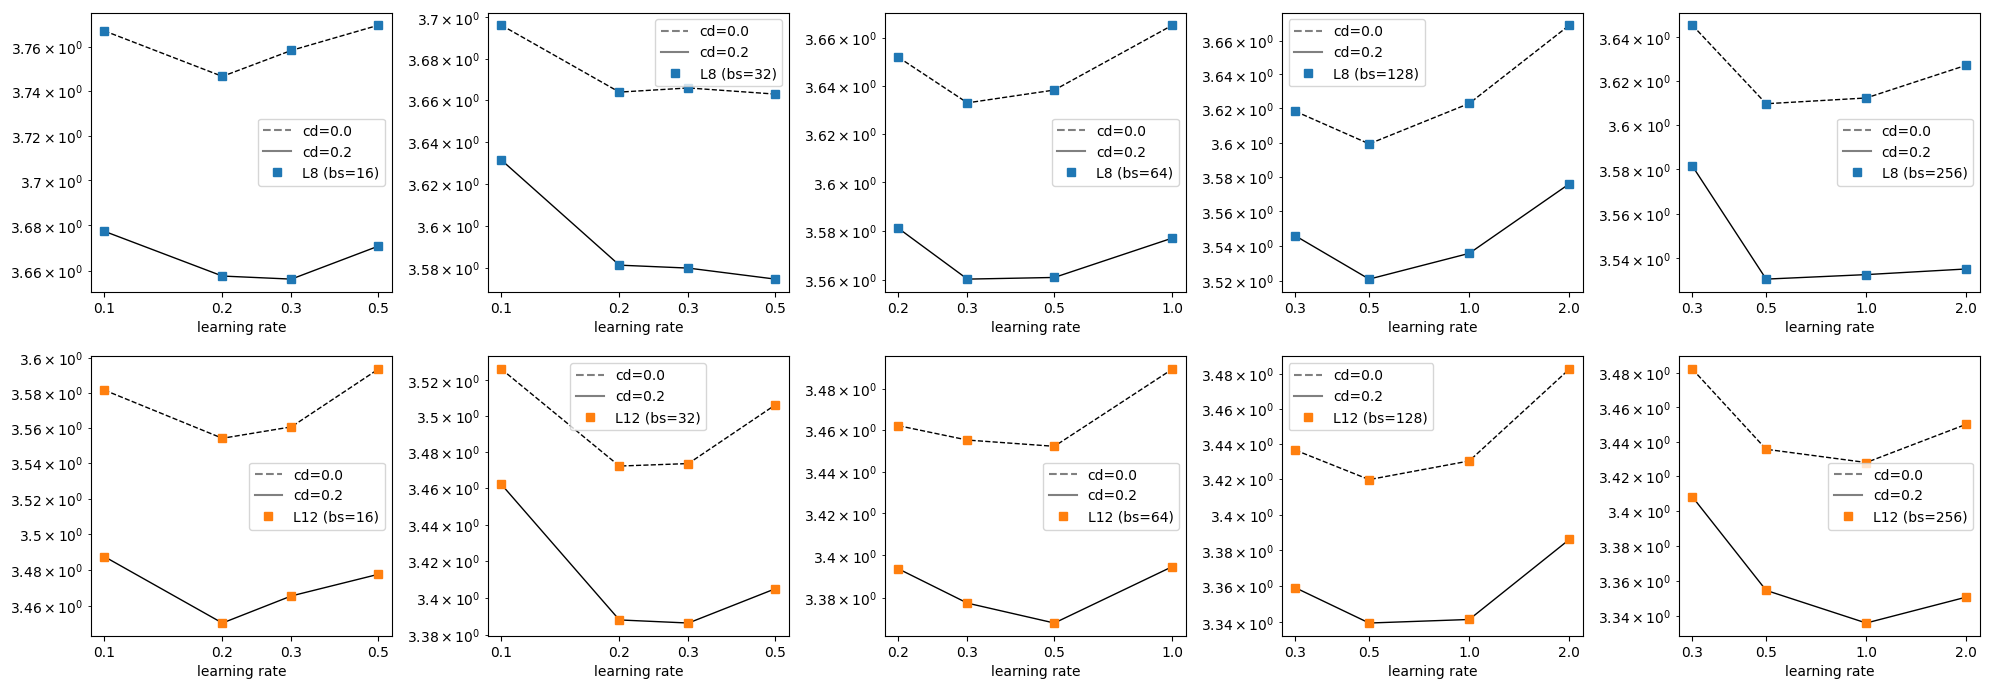

In [6]:
fig = plt.figure(figsize=(20, 7))

optimal_ids = []

plt_idx = 1
for j, (num_layers, dfi) in enumerate(config_df.groupby("num_layers")):
    for i, (batch_size, dfj) in enumerate(dfi.groupby("batch_size")):
        ax = fig.add_subplot(2, 5, plt_idx)
        plt_idx += 1
        for k, (cooldown, dfk) in enumerate(dfj.groupby("cooldown_steps")):
            dfk = dfk.sort_values("lr")
            xs = dfk["lr"].values
            ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfk.index])

            optimal_idx = dfk.index[np.argmin(ys)]
            optimal_ids.append(optimal_idx)

            linestyle = "-" if cooldown == 0.2 else "--"
            # if j == 0:
            ax.plot([], [], label=f"cd={cooldown}", linestyle=linestyle, color=f"gray")
            # ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle=linestyle, color=f"C{j}", marker="s")
            ax.plot(xs, ys, linestyle=linestyle, color="black", linewidth=1.0, marker="none")
            ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle="none", color=f"C{j}", marker="s")

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xticks(sorted(set(xs)), [f"{x}" for x in sorted(set(xs))], minor=False)
        ax.set_xticks([], [], minor=True)
        ax.set_xlabel("learning rate")
        ax.legend()

fig.tight_layout()
fig.show()     

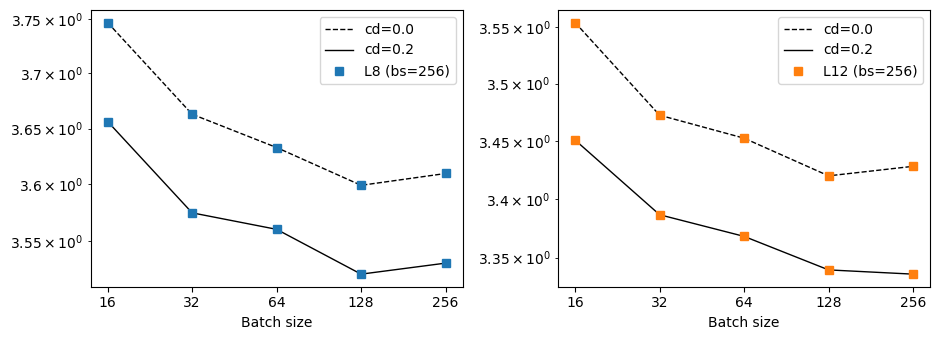

In [7]:
optimal_df = config_df.loc[optimal_ids]

fig = plt.figure(figsize=(9.5, 3.5))

plt_idx = 1
for i, (num_layers, dfi) in enumerate(optimal_df.groupby("num_layers")):
    ax = fig.add_subplot(1, 2, plt_idx)
    plt_idx += 1
    for j, (cooldown, dfj) in enumerate(dfi.groupby("cooldown_steps")):
        dfj = dfj.sort_values("batch_size")
        xs = dfj["batch_size"].values
        ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfj.index])

        linestyle = "-" if cooldown == 0.2 else "--"
        # if j == 0:
        ax.plot([], [], label=f"cd={cooldown}", linestyle=linestyle, color=f"black", linewidth=1.0)
        ax.plot(xs, ys, linestyle=linestyle, color="black", linewidth=1.0, marker="none")
        ax.plot(xs, ys, label=f"L{num_layers} (bs={batch_size})" if cooldown == 0.2 else None, linestyle="none", color=f"C{i}", marker="s")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(sorted(set(xs)), [f"{x}" for x in sorted(set(xs))], minor=False)
    ax.set_xticks([], [], minor=True)
    ax.set_xlabel("Batch size")
    ax.legend()

fig.tight_layout()
fig.show()     

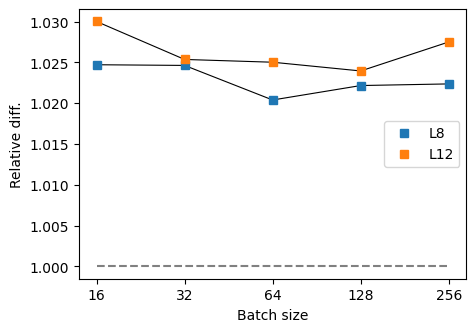

In [8]:
optimal_df = config_df.loc[optimal_ids]

fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_subplot(1, 1, 1)

plt_idx = 1
for i, (num_layers, dfi) in enumerate(optimal_df.groupby("num_layers")):
    plt_idx += 1
    dfi = dfi.sort_values("batch_size")
    xs = dfi[dfi["cooldown_steps"] == 0.2]["batch_size"].values

    elbo_w_cd = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfi[dfi["cooldown_steps"] == 0.2].index])
    elbo_wo_cd = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfi[dfi["cooldown_steps"] == 0.0].index])
    ys = elbo_wo_cd / elbo_w_cd

    # ax.plot([], [], label=f"cd={cooldown}", linestyle=linestyle, color=f"black", linewidth=1.0)
    ax.plot(xs, ys, linestyle=linestyle, color="black", linewidth=0.8, marker="none")
    ax.plot(xs, ys, label=f"L{num_layers}" if cooldown == 0.2 else None, linestyle="none", color=f"C{i}", marker="s")


    for j, (cooldown, dfj) in enumerate(dfi.groupby("cooldown_steps")):
        xs = dfj["batch_size"].values
        ys = np.array([histories[i]["train/elbo"].iloc[-10:].mean() for i in dfj.index])

        linestyle = "-" if cooldown == 0.2 else "--"
        # if j == 0:

ax.plot(xs, [1.0 for _ in xs], linestyle="--", color="gray")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xticks(sorted(set(xs)), [f"{x}" for x in sorted(set(xs))], minor=False)
ax.set_xticks([], [], minor=True)
ax.set_xlabel("Batch size")
ax.set_ylabel("Relative diff.")
ax.legend()

fig.show()     

### Cooldown exp. 2

In [9]:
runs, histories, config_df = load_runs(
    filters={
        "tags": "cooldown_exp_2",
        "state": "finished",
    },
    order="config.batch_size",
)
len(runs)

48

In [10]:
config_df.loc[(config_df["lr"] == 0.3) & (config_df["cooldown_steps"] == 0.0)]["name"].tolist()

['gidd-L12-D768-H12-N2048-bs=32-T=128k-lr=0.3-cd=0.0',
 'gidd-L8-D512-H8-N2048-bs=32-T=128k-lr=0.3-cd=0.0']

(3.25, 4.2)

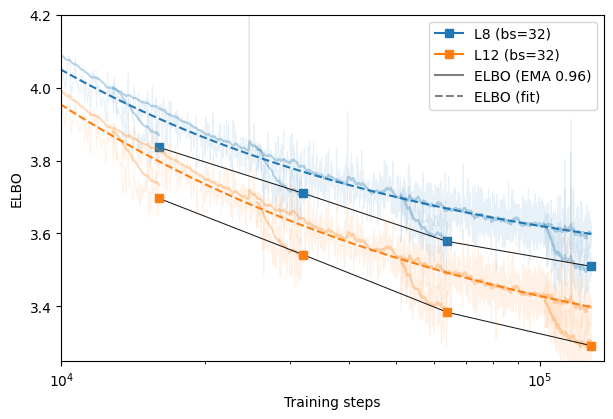

In [12]:
fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(1, 1, 1)

dfi = config_df.loc[(config_df["lr"] == 0.3) & (config_df["cooldown_steps"] == 0.2)]

dfi = dfi.sort_values("max_training_steps")

for i, (num_layers, dfj) in enumerate(dfi.groupby("num_layers")):
    color = f"C{i}"
    final_steps = []
    final_losses = []
    for j, idx in enumerate(dfj.index):
        history = histories[idx]
        final_steps.append(history["_step"].iloc[-1])
        final_losses.append(history["train/elbo"].iloc[-5:].mean())
        cooldown_start = history["_step"].iloc[-1] * (1 - dfj.loc[idx, "cooldown_steps"])
        h = history.loc[history["_step"] >= cooldown_start]
        ax.plot(h["_step"], h["train/elbo"], alpha=0.1, color=color, linewidth=0.75)
        ax.plot(h["_step"], h["train/elbo_ema"], color=color, alpha=0.3)

    plt.plot(final_steps, final_losses, marker="none", linestyle="-", color="black", linewidth=0.75, alpha=0.9)
    plt.plot(final_steps, final_losses, marker="s", linestyle="none", color=color)

dfi = config_df.loc[(config_df["lr"] == 0.3) & (config_df["cooldown_steps"] == 0.0)]
for i, (num_layers, dfj) in enumerate(dfi.groupby("num_layers")):
    idx = dfj.index[0]
    h = histories[idx]
    color = f"C{i}"
    ax.plot(h["_step"], h["train/elbo"], alpha=0.1, color=color, linewidth=0.75)
    ax.plot(h["_step"], h["train/elbo_ema"], color=color, alpha=0.3)
    ax.plot(h["_step"], h["train/elbo_fit"], color=color, alpha=1.0, linestyle="--")

ax.plot([], [], linestyle="-", marker="s", color="C0", label="L8 (bs=32)")
ax.plot([], [], linestyle="-", marker="s", color="C1", label="L12 (bs=32)")
ax.plot([], [], linestyle="-", color="gray", label="ELBO (EMA 0.96)")
ax.plot([], [], linestyle="--", color="gray", label="ELBO (fit)")
ax.set_ylabel("ELBO")
ax.set_xlabel("Training steps")
ax.legend()

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(10000, 136000)
ax.set_ylim(3.25, 4.2)